# Transfer Learning

* [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/transfer-learning/)

1. 실질적으로 Convolution network을 처음부터 학습시키는 일은 많지 않습니다. 대부분의 문제는 이미 학습된 모델을 사용해서 문제를 해결할 수 있습니다.
2. 복잡한 모델일수록 학습시키기 어렵습니다. 어떤 모델은 2주정도 걸릴수 있으며, 비싼 GPU 여러대를 사용하기도 합니다.
3. layers의 갯수, activation, hyper parameters등등 고려해야 할 사항들이 많으며, 실질적으로 처음부터 학습시키려면 많은 시도가 필요합니다.

결론적으로 **이미 잘 훈련된 모델이 있고, 해당 모델과 <span style="color:red">유사한</span> 문제를 해결시 transfer learining을 사용**합니다.

# 실질적 조언

#### 새로 훈련할 데이터가 적지만 original 데이터와 유사할 경우

데이터의 양이 적어 fine-tune (전체 모델에 대해서 backpropagation을 진행하는 것) 은 over-fitting의 위험이 있기에 하지 않습니다. <br>
새로 학습할 데이터는 original 데이터와 유사하기 때문에 이 경우 최종 linear classfier 레이어만 학습을 합니다. 

#### 새로 훈련할 데이터가 매우 많으며 original 데이터와 유사할 경우

새로 학습할 데이터의 양이 많다는 것은 over-fitting의 위험이 낮다는 뜻이므로, 전체 레이어에 대해서 fine-tune을 합니다.

#### 새로 훈련할 데이터가 적으며 original 데이터와 다른 경우

데이터의 양이 적기 때문에 최종 단계의 linear classifier 레이어를 학습하는 것이 좋을 것입니다. 반면서 데이터가 서로 다르기 때문에 거의 마지막부분 (the top of the network)만 학습하는 것은 좋지 않습니다. 서로 상충이 되는데.. 이 경우에는 네트워크 초기 부분 어딘가 activation 이후에 특정 레이어를 학습시키는게 좋습니다.

#### 새로 훈련할 데이터가 많지만 original 데이터와와 다른 경우

데이터가 많기 때문에 아예 새로운 ConvNet을 만들수도 있지만, 실적적으로 transfer learning이 더 효율이 좋습니다. 
전체 네트워크에 대해서 fine-tune을 해도 됩니다.

# Code

아래 예제의 코드에서는 Inception v3를 사용합니다. <br>
Inception v3는 ImageNet이라는 데이터를 분류하는데 학습이 되어 있으며 여기에는 새로 학습할 데이터 '개미' 그리고 '벌' 이 이미 있습니다.<br>
새로 학습할 데이터의 양이 적지만, 기존 모델이 학습한 ImageNet의 데이터와 유사하기 때문에 <br>
전체 fine-tuning을 하지 않고 최종 linear classifier layer부분만 학습하는 방식을 택했습니다. 

> 실제 fine-tune (전체 네트워크 학습)시에는 오히려 accuracy가 0.6수준으로 떨어져 버립니다.

In [1]:
%pylab inline
import torch
import numpy as np
import torchvision
import os

from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

Populating the interactive namespace from numpy and matplotlib


In [2]:
USE_CUDA = torch.cuda.is_available()
BATCH_SIZE = 6
FINE_TUNE = False # True: 전체 네트워크 학습, False: 최종 마지막 network만 학습

### Data

해결하려는 문제는 **개미** 와 **벌**을 구분하는 것입니다.<br>
개미 그리고 벌 각각 120개의 training 이미지가 있고, 75개의 validation images가 있습니다.

In [3]:
train_transform = transforms.Compose([
    transforms.RandomSizedCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Scale(300),
    transforms.CenterCrop(300),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder('hymenoptera_data/train/', train_transform)
test_data = datasets.ImageFolder('hymenoptera_data/val', test_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

### Visualize data

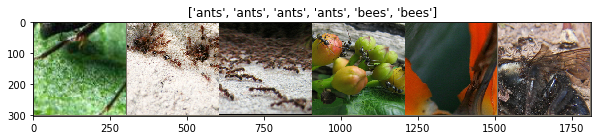

In [4]:
def sample_show():
    # Get a batch of training data
    inp, classes = next(iter(train_loader))
    title = [train_data.classes[i] for i in classes]
    # Make a grid from batch
    inp = torchvision.utils.make_grid(inp, nrow=8)
    
    figsize(10, 10)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

sample_show()

### ConvNet as fixed feature extractor 

ConvNet as fixed feature extractor 기법은 fine-tune처럼 전체 network를 모두 training시키는 기법이 아니라, <br>
마지막 classifier 부분만 학습시킵니다. 

이경우 이미 학습된 모델을 가져온뒤 마지막 fully-connected layer부분만 새로 만듭니다.<br>
학습시 마지막 fully-connected layer만 학습되게 하고 나머지 layers들은 학습되지 않도록 막습니다.

In [5]:
inception = models.inception_v3(pretrained=True)

# Auxiliary 를 사용하지 않으면 inception v2와 동일
inception.aux_logits = False

# 일단 모든 layers를 requires_grad=False 를 통해서 학습이 안되도록 막습니다.
if not FINE_TUNE:
    for parameter in inception.parameters():
        parameter.requires_grad = False

# 새로운 fully-connected classifier layer 를 만들어줍니다. (requires_grad 는 True)
# in_features: 2048 -> in 으로 들어오는 feature의 갯수
n_features = inception.fc.in_features
inception.fc = nn.Linear(n_features, 2) 

if USE_CUDA:
    inception = inception.cuda()
    
criterion = nn.CrossEntropyLoss()

# Optimizer에는 requires_grad=True 인 parameters들만 들어갈수 있습니다.
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, inception.parameters()), lr=0.001)

### Train

In [6]:
def train_model(model, criterion, optimizer, epochs=30):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, (inputs, y_true) in enumerate(train_loader):
            if USE_CUDA:
                x_sample, y_true = inputs.cuda(), y_true.cuda()
            x_sample, y_true = Variable(x_sample), Variable(y_true)

            # parameter gradients들은 0값으로 초기화 합니다. 
            optimizer.zero_grad()

            # Feedforward
            y_pred = inception(x_sample)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            
            _loss = loss.data[0]
            epoch_loss += _loss
        
        print(f'[{epoch+1}] loss: {epoch_loss/step:.4}')

train_model(inception, criterion, optimizer)

[1] loss: 0.7296
[2] loss: 0.3917
[3] loss: 0.3928
[4] loss: 0.3662
[5] loss: 0.4185
[6] loss: 0.2974
[7] loss: 0.4119
[8] loss: 0.3479
[9] loss: 0.3537
[10] loss: 0.3156
[11] loss: 0.3541
[12] loss: 0.3706
[13] loss: 0.3542
[14] loss: 0.4519
[15] loss: 0.4096
[16] loss: 0.3369
[17] loss: 0.4066
[18] loss: 0.3835
[19] loss: 0.339
[20] loss: 0.3388
[21] loss: 0.4563
[22] loss: 0.2894
[23] loss: 0.4607
[24] loss: 0.4162
[25] loss: 0.4597
[26] loss: 0.3222
[27] loss: 0.3771
[28] loss: 0.3897
[29] loss: 0.3431
[30] loss: 0.329


### Validation

In [20]:
def validate(model, epochs=1):
    model.train(False)
    n_total_correct = 0
    for step, (inputs, y_true) in enumerate(test_loader):
        if USE_CUDA:
            x_sample, y_true = inputs.cuda(), y_true.cuda()
        x_sample, y_true = Variable(x_sample), Variable(y_true)

        y_pred = model(x_sample)
        _, y_pred = torch.max(y_pred.data, 1)
        
        n_correct = torch.sum(y_pred == y_true.data)
        n_total_correct += n_correct
        
    print('accuracy:', n_total_correct/len(test_loader.dataset))

validate(inception)

accuracy: 0.9215686274509803
